<a href="https://colab.research.google.com/github/bekku/deeplearning/blob/master/202006_4_wip%E3%81%AB%E5%90%91%E3%81%91%E3%81%A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import time

from google.colab import drive #インポート
drive.mount('/content/gdrive') #GoogleDriveのマウント

torch.cuda.is_available()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


True

In [ ]:
def load_cifar10(batch=128):
    train_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=True,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                [0.5, 0.5, 0.5],  # RGB 平均
                                [0.5, 0.5, 0.5]   # RGB 標準偏差
                                )
                         ])),
        batch_size=batch,
        shuffle=True
    )

    test_loader = DataLoader(
        datasets.CIFAR10('./data',
                         train=False,
                         download=True,
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 [0.5, 0.5, 0.5],  # RGB 平均
                                 [0.5, 0.5, 0.5]  # RGB 標準偏差
                             )
                         ])),
        batch_size=batch,
    )

    return {'train': train_loader, 'test': test_loader}

# **与えられたリストからNNモデルの生成関数**

### 問題

あるN + 1 個の要素を持つ数列 A が与えられる。高橋くんは、与えられた数列の情報から隠れ層が N 個となるNNモデルを作成したい。数列のA1は、N である。
また、Aiは各NNモデルの隠れ層iのノード数となる。
それを満たすNNモデルを生成せよ。
NNの入力層のノード数は3×32×32であり、出力層のノード数は10である。

### 制約

1 <= N <= INF

### 入力

[ N , A1 , A2 , , , , , AN ]

In [ ]:
class CreateNet1(torch.nn.Module):
    def __init__(self, NN_model_list):
        super(CreateNet, self).__init__()

        for i in range(NN_model_list[0]):
            if i==0:
                self._modules["fc"+str(i+1)]= torch.nn.Linear(3 * 32 * 32, NN_model_list[1])
                #入力層
            else:
                self._modules["fc"+str(i+1)]= torch.nn.Linear(NN_model_list[i], NN_model_list[i+1])
                #出力層 fcリストの個数は、常にNN_model_list[0]+1である。
        self._modules["fc"+str(i+2)]= torch.nn.Linear(NN_model_list[-1], 10)

    def forward(self, x):
        for i in range(len(self._modules)-1):
            x = f.relu(self._modules["fc"+str(i+1)](x))
        x = self._modules["fc"+str(len(self._modules))](x)
        return f.log_softmax(x, dim=1)


# **与えられたリストからNNモデルの生成関数2**

### 問題

ある N 個の要素を持つ数列 A が与えられる。高橋くんは、与えられた数列の情報から、NNモデルを作成したい。
Aiは各NNモデルの隠れ層 i のノード数となる。隠れ層 i のノード数が0となる場合、その層 i は層とみなさないものとして生成する。
上記を満たす、NNモデルを生成せよ。
NNの入力層のノード数は3×32×32であり、出力層のノード数は10である。

### 制約

1 <= N <= INF

### 入力

[ A1 , A2 , , , , , AN ]

In [ ]:
class CreateNet(torch.nn.Module):
    def __init__(self, NN_model_list):
        super(CreateNet, self).__init__()

        self.NN_model_list_2=[]
        for i in range(len(NN_model_list)):
            if NN_model_list[i]!=0:
                self.NN_model_list_2.append(NN_model_list[i])

        NN_model_list=[len(self.NN_model_list_2)]+self.NN_model_list_2

        for i in range(len(NN_model_list)-1):
            if i==0:
                self._modules["fc"+str(i+1)]= torch.nn.Linear(3 * 32 * 32, NN_model_list[1])
                #入力層
            else:
                self._modules["fc"+str(i+1)]= torch.nn.Linear(NN_model_list[i], NN_model_list[i+1])
                #出力層 fcリストの個数は、常にNN_model_list[0]+1である。
        self._modules["fc"+str(i+2)]= torch.nn.Linear(NN_model_list[-1], 10)

    def forward(self, x):
        for i in range(len(self._modules)-1):
            x = f.relu(self._modules["fc"+str(i+1)](x))
        x = self._modules["fc"+str(len(self._modules))](x)
        return f.log_softmax(x, dim=1)


In [ ]:
#実際に作られました

NN_model_list=[3,1024,1024,256]
# print(*CreateNet(NN_model_list).parameters())
# print(vars(CreateNet(NN_model_list))
# ValueError: optimizer got an empty parameter list!の対策として、paraの確認。
# 下のvarsによって、クラスの変数を列挙して、モデルのパラに重要なorderdictが_modulesに入ることになる。

NN_model_list=[1024,256]
print(CreateNet(NN_model_list))
# NN_model_list=[1,1024]
# print(CreateNet(NN_model_list))

CreateNet(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


生成モデルを動かしてみた。

Test loss (avg): 2.092606781387329, Accuracy: 0.5381
Training log: 14 epoch (128 / 50000 train. data). Loss: 0.3713621199131012
Training log: 14 epoch (11648 / 50000 train. data). Loss: 0.4288032650947571
Training log: 14 epoch (23168 / 50000 train. data). Loss: 0.3333142101764679
Training log: 14 epoch (34688 / 50000 train. data). Loss: 0.4205192029476166
Training log: 14 epoch (46208 / 50000 train. data). Loss: 0.44838231801986694
Test loss (avg): 2.286080798912048, Accuracy: 0.5422
Training log: 15 epoch (128 / 50000 train. data). Loss: 0.2954057455062866
Training log: 15 epoch (11648 / 50000 train. data). Loss: 0.44230884313583374
Training log: 15 epoch (23168 / 50000 train. data). Loss: 0.3482576608657837
Training log: 15 epoch (34688 / 50000 train. data). Loss: 0.28801873326301575
Training log: 15 epoch (46208 / 50000 train. data). Loss: 0.35611245036125183
Test loss (avg): 2.4215006090164186, Accuracy: 0.5476
Training log: 16 epoch (128 / 50000 train. data). Loss: 0.378745764493

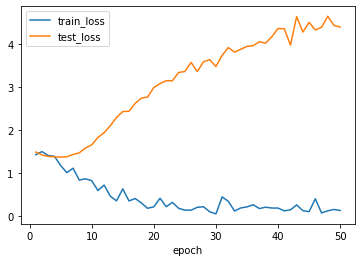

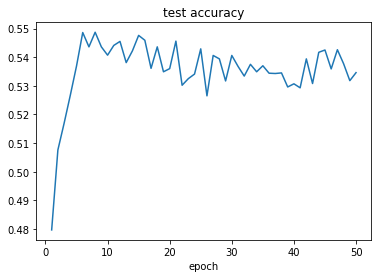

In [ ]:
from torchsummary import summary
NN_model_list=[1024,1024,256]

if __name__ == '__main__':
    epoch = 50
    history = {
        'train_loss': [],
        'test_loss': [],
        'test_acc': [],
    }

    net: torch.nn.Module = CreateNet(NN_model_list)
    loaders = load_cifar10()

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)

    for e in range(epoch):

        """ Training Part"""
        loss = None
        # 学習開始 (再開)
        net.train(True)  
        for i, (data, target) in enumerate(loaders['train']):
            data = data.to(device)  # to GPU?
            target = target.to(device)
            data = data.view(-1, 32 * 32 * 3)
            optimizer.zero_grad()
            output = net(data)
            loss = f.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if i % 90 == 0:
                print('Training log: {} epoch ({} / 50000 train. data). Loss: {}'.format(e+1,
                                                                                         (i+1)*128,
                                                                                         loss.item())
                      )
        history['train_loss'].append(loss)
        
        """ Test Part """
        # 学習のストップ
        net.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in loaders['test']:
                data = data.to(device)  # to GPU?
                target = target.to(device)
                data = data.view(-1, 32 * 32 * 3)
                output = net(data)
                test_loss += f.nll_loss(output, target, reduction='sum').item()                
                pred = output.argmax(dim=1, keepdim=True)
                
                correct += pred.eq(target.view_as(pred)).sum().item()
                #eqっていうのは、同じ値だとTrueをとる。

        test_loss /= 10000

        print('Test loss (avg): {}, Accuracy: {}'.format(test_loss,
                                                         correct / 10000))

        history['test_loss'].append(test_loss)
        history['test_acc'].append(correct / 10000)
        
    #====== 保存 =======
    path = "/content/gdrive/My Drive/コード/202006-4周目/rundom_model_weight.pth" # 保存先pathの設定
    torch.save(net.state_dict(), path) # 保存

    # 結果の出力と描画
    print(history)
    plt.figure()
    plt.plot(range(1, epoch+1), history['train_loss'], label='train_loss')
    plt.plot(range(1, epoch+1), history['test_loss'], label='test_loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig('loss.png')

    plt.figure()
    plt.plot(range(1, epoch+1), history['test_acc'])
    plt.title('test accuracy')
    plt.xlabel('epoch')
    plt.savefig('test_acc.png')

In [ ]:
NNnet: CreateNet = CreateNet(NN_model_list)
    
# 保存したモデルのパラメータ
param = torch.load('/content/gdrive/My Drive/コード/202006-4周目/rundom_model_weight.pth')

# 保存したモデルにパラメータを当てはめる
NNnet.load_state_dict(param)

<All keys matched successfully>

# **正規化評価関数作成**

引数を速度とaccuracyを取ります。

速度の最小と最大も欲しい。(最小=0,最大=元モデル)

精度の最小と最大も欲しい。(最小=0,最大=1 or 元モデル精度)

**問題：精度0を許すと速度が振り切れるってのがあるから、改善の余地**

速度は速いほど0.5に近づき、精度は高いほど0.5に近づく。

合計で1.0が最高のパフォーマンス。ちなありえない。

In [ ]:
def speed_acc_normalization(spe_max,spe_min,spe,acc_max,acc_min,acc):
    if spe_min<=spe<=spe_max:
        speed_normalization = ((spe_max-spe+1) - spe_min) / ( (spe_max - spe_min) * 2 )
    else:
        speed_normalization=0
    if acc_min<=acc<=acc_max:
      accuracy_normalization = (acc - acc_min) / ( (acc_max - acc_min) * 2 )
    else:
        accuracy_normalization=0

    print(speed_normalization)
    print(accuracy_normalization)

    return speed_normalization + accuracy_normalization

In [ ]:
import time
loader = load_cifar10()
t1 = time.time()


correct = 0
with torch.no_grad():
    for images, labels in loader['test']:
        data = images.view(-1, 32 * 32 * 3)
        outputs = NNnet(data)
        _, predicted = torch.max(outputs.data, 1)
        #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
        correct += (predicted == labels).sum().item()

acc = float(correct / 10000)
print(acc)


t2 = time.time()
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")

print(speed_acc_normalization(5,0,elapsed_time,1,0,acc))


## **教師モデルと温度付きソフトマックス**

In [ ]:
#教師モデル
#####ドロップアウトを除いた推論用モデル#######
#ここで温度を変更して、softターゲットとする。


class T_CNN(torch.nn.Module):
    def __init__(self):
        super(T_CNN, self).__init__()

        self.conv1 = torch.nn.Conv2d(3, 32, 3, 1, 0)
        self.conv2 = torch.nn.Conv2d(32, 32, 3)
        self.conv3 = torch.nn.Conv2d(32, 64, 3)
        self.conv4 = torch.nn.Conv2d(64, 64, 3)
        
        self.dropout1 = torch.nn.Dropout2d(p=0.25)
        self.dropout2 = torch.nn.Dropout2d(p=0.5)

        self.pool = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(64 * 5 * 5, 512) 
        self.fc2 = torch.nn.Linear(512, 10)

    def forward(self, x, T):
        x = f.relu(self.conv1(x))
        x = f.relu(self.conv2(x))
        x = self.pool(x)
        
        x = f.relu(self.conv3(x))
        x = f.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 64 * 5 * 5)
        x = f.relu(self.fc1(x))
        x = self.fc2(x)
        x = x/T

        return f.softmax(x)

class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = torch.nn.Linear(32 * 32 * 3, 1024)
        self.fc2 = torch.nn.Linear(1024, 10)

    def forward(self, x, T):
        x = f.relu(self.fc1(x))
        x = self.fc2(x)
        x = x/T
        return f.log_softmax(x)
# 教師モデルと生徒モデルのcross_entropyの損失関数の定義
class T_S_Closs_entropy(torch.nn.Module):
    def __init__(self):
        super(T_S_Closs_entropy, self).__init__()

    def forward(self, p, q):
        #pが教師モデル、qが生徒モデルの出力値(既に対数化してます)です。
        # c = torch.max(q)
        loss = p*q
        loss = torch.sum(loss)
        loss*=-1
        return loss

Tnet: T_CNN = T_CNN()
param = torch.load('/content/gdrive/My Drive/コード/teacher_model_weight.pth')
Tnet.load_state_dict(param)
loader = load_cifar10()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Tnet.to(device)
t1 = time.time()
correct = 0
with torch.no_grad():
    for images, labels in loader['test']:
        images = images.to(device) 
        labels = labels.to(device)
        outputs = Tnet(images,1)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
a_max = float(correct / 10000)
print(a_max)
t2 = time.time()
s_max = t2-t1
print(f"経過時間：{s_max}")

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.7364
経過時間：2.9531991481781006


## **最終的に遺伝的探索を行うための評価関数**

In [ ]:
# 温度付きモデル生成関数
class CreateNet(torch.nn.Module):
    def __init__(self, NN_model_list):
        super(CreateNet, self).__init__()

        self.NN_model_list_2=[]
        for i in range(len(NN_model_list)):
            if NN_model_list[i]!=0:
                self.NN_model_list_2.append(NN_model_list[i])

        NN_model_list=[len(self.NN_model_list_2)]+self.NN_model_list_2

        for i in range(len(NN_model_list)-1):
            if i==0:
                self._modules["fc"+str(i+1)]= torch.nn.Linear(3 * 32 * 32, NN_model_list[1])
                #入力層
            else:
                self._modules["fc"+str(i+1)]= torch.nn.Linear(NN_model_list[i], NN_model_list[i+1])
                #出力層 fcリストの個数は、常にNN_model_list[0]+1である。
        self._modules["fc"+str(i+2)]= torch.nn.Linear(NN_model_list[-1], 10)

    def forward(self, x, T):
        for i in range(len(self._modules)-1):
            x = f.relu(self._modules["fc"+str(i+1)](x))
        x = self._modules["fc"+str(len(self._modules))](x)
        x = x/T
        return f.log_softmax(x)

# 速度と精度の評価関数これが最大化されたい。
def speed_acc_normalization(spe_max,spe_min,spe,acc_max,acc_min,acc):
    if spe_min<=spe<=spe_max:
        speed_normalization = ((spe_max-spe+1) - spe_min) / ( (spe_max - spe_min) * 2 )
    else:
        speed_normalization=0
    if acc_min<=acc<=acc_max:
      accuracy_normalization = (acc - acc_min) / ( (acc_max - acc_min) * 2 )
    else:
        accuracy_normalization=0
    print("----------------")
    print("速度:{} ,精度:{}".format(spe,acc))
    print("速度評価値:{} ,精度評価値:{}".format(speed_normalization,accuracy_normalization))
    print("評価指標:{}".format(speed_normalization + accuracy_normalization))
    print("----------------")

    return speed_normalization + accuracy_normalization



#　遺伝的評価関数、引数 : gane=層ごとの引数-リスト、temp = 温度、スピード最大、精度最大。
def evaluater(gane,temp,s_max,a_max=1.0):
    Tnet: T_CNN = T_CNN()
    # 保存したモデルのパラメータ
    param = torch.load('/content/gdrive/My Drive/コード/teacher_model_weight.pth')
    # 保存したモデルにパラメータを当てはめる
    Tnet.load_state_dict(param)

    temp=temp
    # 学習回数
    epoch = 50
    net: torch.nn.Module = CreateNet(gane)
    loaders = load_cifar10()

    criterion = T_S_Closs_entropy()

    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    Tnet.to(device)

    for e in range(1,epoch+1):
        """　学習　開始"""
        loss = None
        net.train()
        for data, target in loaders['train']:
                
            data = data.to(device)
            target = target.to(device)

            max_model_outputs = Tnet(data,temp)
            data = data.view(-1, 32 * 32 * 3)
            output = net(data,temp)

            optimizer.zero_grad()
            loss = criterion(max_model_outputs,output)

            loss.backward()
            optimizer.step()
        if e%10==0:
            print('temp: {} ,Training log: {} ,Loss: {}'.format(temp,e,loss.item()))

    """  学習したモデルの速度と精度の評価をする。(推論)"""
    net.eval()
    correct = 0
    t1 = time.time()
    with torch.no_grad():
        for images, labels in loaders['test']:
            images = images.to(device) 
            labels = labels.to(device)
            data = images.view(-1, 32 * 32 * 3)
            outputs = net(data,1)
            _, predicted = torch.max(outputs.data, 1)
            #torch.max(a, axis) (axis=0:col, axis=1:row)ごとに最大値を取ってくれている。
            correct += (predicted == labels).sum().item()

    acc = float(correct / 10000)
    t2 = time.time()
    elapsed_time = t2-t1

    return speed_acc_normalization(s_max,0,elapsed_time,a_max,0,acc)
print("出力")

出力


In [ ]:
eva_t = time.time()
print(evaluater([1024,512] ,10 ,s_max ,a_max))
eva_t2 = time.time()
print("モデル1つ当たりの学習時間:{}".format(eva_t2 -eva_t))

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 10 ,Training log: 10 ,Loss: 178.7676544189453
temp: 10 ,Training log: 20 ,Loss: 179.7474365234375
temp: 10 ,Training log: 30 ,Loss: 179.8099365234375
temp: 10 ,Training log: 40 ,Loss: 178.8997802734375
temp: 10 ,Training log: 50 ,Loss: 178.4928741455078
速度:2.6592020988464355 ,精度:0.5799
速度評価値:0.2190839466633943 ,精度評価値:0.39373981531776203
モデル1つ当たりの学習時間:744.362138748169


In [ ]:
eva_t = time.time()
evaluater([1024] ,10 ,s_max ,a_max)
eva_t2 = time.time()
print("学習時間:{}".format(eva_t2 -eva_t))

eva_t = time.time()
evaluater([1024,512] ,10 ,s_max ,a_max)
eva_t2 = time.time()
print("学習時間:{}".format(eva_t2 -eva_t))

eva_t = time.time()
evaluater([2048,1024,512] ,10 ,s_max ,a_max)
eva_t2 = time.time()
print("学習時間:{}".format(eva_t2 -eva_t))

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


temp: 10 ,Training log: 10 ,Loss: 180.3373565673828
temp: 10 ,Training log: 20 ,Loss: 179.5028839111328
temp: 10 ,Training log: 30 ,Loss: 178.09298706054688
temp: 10 ,Training log: 40 ,Loss: 178.81155395507812
temp: 10 ,Training log: 50 ,Loss: 179.34249877929688
----------------
速度:2.6391704082489014 ,精度:0.5488
速度評価値:0.22247547049779137 ,精度評価値:0.37262357414448666
評価指標:0.595099044642278
----------------
0.595099044642278
学習時間:730.113119840622
Files already downloaded and verified
Files already downloaded and verified
temp: 10 ,Training log: 10 ,Loss: 179.1807098388672
temp: 10 ,Training log: 20 ,Loss: 178.33551025390625
temp: 10 ,Training log: 30 ,Loss: 177.39285278320312
temp: 10 ,Training log: 40 ,Loss: 179.2025146484375
temp: 10 ,Training log: 50 ,Loss: 177.89041137695312
----------------
速度:2.5444624423980713 ,精度:0.5726
速度評価値:0.23851027903910793 ,精度評価値:0.38878326996197715
評価指標:0.6272935490010851
----------------
0.6272935490010851
学習時間:737.5025703907013
Files already downloaded and 